In [1]:
% matplotlib inline
from __future__ import print_function, division
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def read_file(path):
    t0 = time.time()
    df = pd.read_csv(path, na_values=['null', 'Na'])
    print("%.2f secs ==> pd.read_csv"%(time.time()-t0))
    df['useragent_1'] = df['useragent'].apply(lambda x: x.split('_')[0])
    df['useragent_2'] = df['useragent'].apply(lambda x: x.split('_')[1])
    return df

In [3]:
df_train = read_file('./data/train.csv')
df_val = read_file('./data/validation.csv')
df_test = read_file('./data/test.csv')

18.81 secs ==> pd.read_csv
2.38 secs ==> pd.read_csv
2.12 secs ==> pd.read_csv


## Problem 3

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, mean_squared_error

In [5]:
def to_index(df, feature):
    return LabelEncoder().fit_transform(df[feature].values)

def to_one_hot(df, features):
    return OneHotEncoder().fit_transform(df[features].values).toarray()

def hour_fn(hour):
    if hour <= 6:
        return 0
    if 6 < hour <= 12:
        return 1
    if 12 < hour <= 18:
        return 2
    if 18 < hour <= 24:
        return 3

def slot_width_fn(width):
    if width <= 300:
        return 0
    if 300 < width <= 728:
        return 1
    if width > 728:
        return 2

def slot_height_fn(height):
    if height <= 100:
        return 0
    if 100 < height <= 240:
        return 1
    if height > 240:
        return 2

def slot_height_fn(height):
    if height <= 100:
        return 0
    if 100 < height <= 240:
        return 1
    if height > 240:
        return 2
    
def city_fn(city):
    if city <= 93:
        return 0
    if 93 < city <= 187:
        return 1
    if 187 < city <= 303:
        return 2
    if city > 303:
        return 3

def city_fn(city):
    if city <= 93:
        return 0
    if 93 < city <= 187:
        return 1
    if 187 < city <= 303:
        return 2
    if city > 303:
        return 3
    
def region_fn(region):
    if region <= 65:
        return 0
    if 65 < region <= 183:
        return 1
    if 183 < region <= 325:
        return 2
    if region > 325:
        return 3
    
def slot_price_fn(price):
    if price <= 50:
        return 0
    if 50 < price <= 98:
        return 1
    if price > 98:
        return 2
    
def preprocess(df):
    df['hour'] = df['hour'].apply(hour_fn)
    df['slotwidth'] = df['slotwidth'].apply(slot_width_fn)
    df['slotheight'] = df['slotheight'].apply(slot_height_fn)
    df['city'] = df['city'].apply(city_fn)
    df['region'] = df['region'].apply(region_fn)
    df['slotvisibility'] = df['slotvisibility'].apply(lambda x: str(x))
    df['slotformat'] = df['slotformat'].apply(lambda x: str(x))
    df['adexchange'] = df['adexchange'].apply(lambda x: str(x))
    df['slotprice'] = df['slotprice'].apply(slot_price_fn)
    
    for feat in ['useragent_1', 'useragent_2', 'advertiser', 'slotvisibility', 'slotformat', 'adexchange']:
        df[feat] = to_index(df, feat)
    
    one_hot = to_one_hot(df,
        ['weekday', 'hour', 'useragent_1', 'useragent_2', 'city', 'region', 'adexchange',
         'slotwidth', 'slotheight', 'slotvisibility', 'slotformat', 'slotprice',
         'advertiser',])
    
    return one_hot

def simulation(df, bid_vals, base_bid):
    budget = 6250
    paid = 0
    clicks = 0
    for idx, row in df.iterrows():
        if paid > budget:
            break
        
        if bid_vals[idx] >= row['payprice']:
            if row['click'] == 1:
                clicks += 1
            paid += (row['payprice'] / 1000)
    imps = idx + 1
    ctr = clicks / imps * 100
    cpm = ((paid / imps) * 1000)
    cpc = paid / clicks
    return clicks, ctr, paid, cpm, cpc, idx, len(df)

def plot_roc(y_val, y_val_proba):
    fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
    f, axes = plt.subplots(1, figsize=(8, 5))
    lab = 'AUC=%.5f' % auc(fpr, tpr)
    axes.step(fpr, tpr, lw=2,label=lab)
    axes.legend(loc='lower right', fontsize='small')
    plt.show()

(181093, 72) (303925, 72)


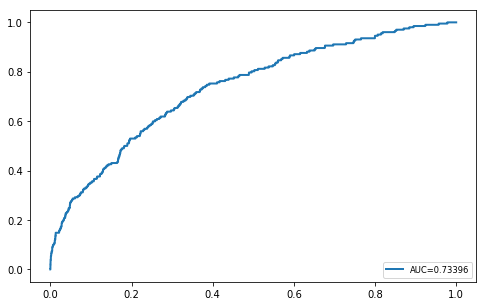

In [6]:
ratio = 100
pos_df = df_train[df_train['click']==1]
neg_df = df_train[df_train['click']==0]
reduced_neg_df = neg_df.sample(ratio*len(pos_df), random_state=100)
down_sample_df = pd.concat([pos_df]+[reduced_neg_df], ignore_index=True)

X_train = preprocess(down_sample_df.copy())
y_train = down_sample_df['click'].values

X_val = preprocess(df_val.copy())
y_val = df_val['click'].values

print(X_train.shape, X_val.shape)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_val_pred = clf.predict(X_val)
y_val_proba = clf.predict_proba(X_val)[:, 1]
plot_roc(y_val, y_val_proba)

In [7]:
avgCTR = df_train['click'].values.mean()
base_bid = 5.5
pCTRs = y_val_proba
bid_vals = pCTRs * base_bid / avgCTR
print(bid_vals)

clicks, ctr, paid, cpm, cpc, idx, total_rows = simulation(df_val, bid_vals, base_bid)
print("Linear Bidding | Clicks: %d | CTR: %.3f | Spent: %d |  CPM: %.2f | CPC: %.2f | Impressions: %d" % (
    clicks, ctr, paid, cpm, cpc, idx))

[58.53486359 35.49082894 36.39448959 ... 60.76007349 31.1432159
 28.21581999]
Linear Bidding | Clicks: 122 | CTR: 0.040 | Spent: 6054 |  CPM: 19.92 | CPC: 49.63 | Impressions: 303924


In [8]:

from sklearn.ensemble import GradientBoostingClassifier

clf2 = GradientBoostingClassifier()
clf2.fit(X_train, y_train)
y_val_pred = clf2.predict(X_val)
y_val_proba = clf2.predict_proba(X_val)[:, 1]

base_bid = 5.5
pCTRs = y_val_proba
bid_vals = pCTRs * base_bid / avgCTR
print(bid_vals)

clicks, ctr, paid, cpm, cpc, idx, total_rows = simulation(df_val, bid_vals, base_bid)
print("Linear Bidding | Clicks: %d | CTR: %.3f | Spent: %d |  CPM: %.2f | CPC: %.2f | Impressions: %d" % (
    clicks, ctr, paid, cpm, cpc, idx))

X_test = preprocess(df_test.copy())
pCTRs = clf.predict_proba(X_test)[:, 1]
bid_vals = pCTRs * base_bid / avgCTR
df_submit = pd.read_csv('./data/Group_7.csv')
df_submit['bidprice'] = bid_vals
df_submit.to_csv('./testing_bidding_price.csv', index=False)


[ 59.28129357  44.10867718  35.95298757 ... 114.05590384  45.25067469
  33.80799625]
Linear Bidding | Clicks: 128 | CTR: 0.042 | Spent: 6023 |  CPM: 19.82 | CPC: 47.06 | Impressions: 303924


## Problem 5

#### Method 1: GBDT + LR

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

class GBDT_LR:
    def __init__(self):
        self.gbdt = GradientBoostingRegressor()
        self.lr = LogisticRegression()
        self.one_hot = OneHotEncoder()

    def fit(self, X_train, y_train):
        self.gbdt.fit(X_train, y_train)
        X_leaves = self.gbdt.apply(X_train)
        X_feats = self.one_hot.fit_transform(X_leaves).toarray()
        self.lr.fit(X_feats, y_train)
        
    def predict_proba(self, X_test):
        X_leaves = self.gbdt.apply(X_test)
        X_feats = self.one_hot.transform(X_leaves).toarray()
        return self.lr.predict_proba(X_feats)

clf = GBDT_LR()
clf.fit(X_train, y_train)
y_val_proba = clf.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
rmse = np.sqrt(mean_squared_error(y_val, y_val_proba))
print("AUC=%.3f | RMSE=%.3f" % (auc(fpr, tpr), rmse))

AUC=0.722 | RMSE=0.031


#### Method 2: Voting

In [12]:
from sklearn.ensemble import VotingClassifier

clf = VotingClassifier([('LR', LogisticRegression()),
                        ('XGBoost', XGBClassifier()),
                        ('LightGBM', LGBMClassifier())], voting='soft')
clf.fit(X_train, y_train)
y_val_proba = clf.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
rmse = np.sqrt(mean_squared_error(y_val, y_val_proba))
print("AUC=%.3f | RMSE=%.3f" % (auc(fpr, tpr), rmse))

AUC=0.746 | RMSE=0.030
